# Training classifiers on several feature sets

Here we construct datasets for the different combinations of features (CNN, biomarkers, radiomics) and train classifiers to predict malignancy

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import torch
from LIDC_dataset import LIDC
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn import model_selection, preprocessing, svm, tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from torchvision import transforms
from tqdm import tqdm
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(style="ticks")
set_matplotlib_formats("pdf", "svg")

In [2]:
%load_ext autoreload
%autoreload 2
from CNNModelFinetune import CNNModelFinetune
from conceptModelFinetune import conceptModelFinetune
from LIDCDataModule import LIDCDataModule

In [3]:
device = "cuda:0"

In [4]:
data_path = "/home/lbrocki/ConRad/dataset"

### preparing biomarker features

Note: the terms _biomarkers_ and _concepts_ are used interchangeably

In [5]:
df_ann = pd.read_pickle(f"{data_path}/annotations_df.pkl")

In [6]:
concepts = [
    "subtlety",
    "calcification",
    "margin",
    "lobulation",
    "spiculation",
    "diameter",
    "texture",
    "sphericity",
]
# diameter are extracted by pyradiomics, so we exclude them from concepts
select_concepts = [
    "subtlety",
    "calcification",
    "margin",
    "lobulation",
    "spiculation",
    # "diameter",
    "texture",
    "sphericity",
]

In [7]:
X_concepts = df_ann[concepts].to_numpy()
X_concepts_select = df_ann[select_concepts].to_numpy()
y = df_ann["target"]

In [8]:
num_all = len(X_concepts)
indices_full = list(range(num_all))

### preparing radiomics features

In [9]:
shape_radiomics_df = pd.read_pickle(f"{data_path}/radiomics_features/shape_radiomic_df.pkl")
gldm_radiomics_df = pd.read_pickle(f"{data_path}/radiomics_features/gldm_radiomic_df.pkl")
ngtdm_radiomics_df = pd.read_pickle(f"{data_path}/radiomics_features/ngtdm_radiomic_df.pkl")
glcm_radiomics_df = pd.read_pickle(f"{data_path}/radiomics_features/glcm_radiomic_df.pkl")
glrlm_radiomics_df = pd.read_pickle(f"{data_path}/radiomics_features/glrlm_radiomic_df.pkl")
glszm_radiomics_df = pd.read_pickle(f"{data_path}/radiomics_features/glszm_radiomic_df.pkl")
firstorder_radiomics_df = pd.read_pickle(f"{data_path}/radiomics_features/firstorder_radiomic_df.pkl")

y = df_ann["target"]

In [10]:
# merge all radiomics features in a single df
all_radiomics_df = pd.concat(
    [
        shape_radiomics_df,
        gldm_radiomics_df,
        ngtdm_radiomics_df,
        glcm_radiomics_df,
        glrlm_radiomics_df,
        glszm_radiomics_df,
        firstorder_radiomics_df
    ], axis=1)
all_radiomics = all_radiomics_df.to_numpy()
radiomic_names = list(all_radiomics_df.columns)

### defining folds for cross-validation

In [11]:
# notice that the definition of folds is equivalent to the one used in LIDCDataModule.py (random_state=0)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
gen_splits = skf.split(indices_full, y)
train_idx_folds = []
test_idx_folds = []
for train_idx, test_idx in gen_splits:
    train_idx_folds.append(train_idx)
    test_idx_folds.append(test_idx)

In [12]:
def get_fold(fold, X, y):
    X_train = X[train_idx_folds[fold]]
    X_test = X[test_idx_folds[fold]]
    y_train = y[train_idx_folds[fold]]
    y_test = y[test_idx_folds[fold]]

    # z-score scaling of data
    scaler = preprocessing.StandardScaler().fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test

### Combine different feature sets 

#### Extract features

In [13]:
# define which models and weights to use
cnn_model = CNNModelFinetune().to(device)
cnn_model_path = "weights/cnn_finetune_{}.pt"

concept_model = conceptModelFinetune().to(device)
concept_model_path = "weights/concept_finetune_{}.pt"

In [14]:
# register a forward hook to obtain the output of the final convolutional layer after global average pooling
activation = {}

def getActivation(name):
    def hook(bottle_model, input, output):
        activation[name] = output.detach()
    return hook

h1 = cnn_model.model.avgpool.register_forward_hook(getActivation("features"))

In [15]:
def extract_cnn_features(model, dataloader):
    bottleneck = []
    # loop over batches
    for x, _ in dataloader:
        bottleneck_view = torch.zeros((3, len(x[0]), 2048))
        # loop over views
        for i in range(3):
            # this triggers the forward hook
            with torch.no_grad():
                model(x[i].to(device))
            bottleneck_view[i] = torch.squeeze(activation["features"])
        avg = torch.mean(bottleneck_view, axis=0)
        bottleneck.append(avg)
    bottleneck = torch.concat(bottleneck)
    bottleneck = bottleneck.detach().numpy()
    return bottleneck

In [16]:
def get_cnn_features(cnn_model_path):

    cnn_features_train = []
    cnn_features_test = []

    # extract predicted concepts and cnn features
    for fold in range(5):
        print(cnn_model_path.format(fold))
        cnn_model.load_state_dict(torch.load(cnn_model_path.format(fold)))
        cnn_model.eval()
        data_module = LIDCDataModule(
            data_dir=data_path, 
            fold=fold, 
            extract=True, 
            batch_size=32,
            finetune=True,
        )
        data_module.setup()

        train_loader = data_module.train_dataloader()
        test_loader = data_module.test_dataloader()

        # extract features from the CNN model
        cnn_train = extract_cnn_features(cnn_model, train_loader)
        cnn_test = extract_cnn_features(cnn_model, test_loader)

        cnn_features_train.append(cnn_train)
        cnn_features_test.append(cnn_test)
    return cnn_features_train, cnn_features_test

In [17]:
# predict the concepts using concept bottleneck
def get_concept_features(concept_model_path):
    concept_features = []
    for fold in range(5):
        print(concept_model_path.format(fold))
        concept_model.load_state_dict(torch.load(concept_model_path.format(fold)))
        concept_model.eval()

        data_module = LIDCDataModule(data_dir=data_path, fold=fold, extract=True, finetune=True)
        data_module.setup()

        train_loader = data_module.train_dataloader()
        test_loader = data_module.test_dataloader()

        # extract predicted concepts(diameter, spiculation etc..) for test set
        # classifier is trained on concept labels and tested on predicted concepts
        pred_concepts = []
        # loop over batches
        for x, _ in test_loader:
            preds_view = torch.zeros((3, len(x[0]), 8))
            # loop over views
            for i in range(3):
                with torch.no_grad():
                    preds_view[i] = concept_model(x[i].to(device))
            avg = torch.mean(preds_view, axis=0)
            pred_concepts.append(avg)
        pred_concepts = torch.concat(pred_concepts)
        pred_concepts = pred_concepts.detach().numpy()
        
        concept_features.append(pred_concepts)
    return concept_features

In [18]:
def combine_features(feature_list_train, feature_list_test = []):
    combined_train = np.concatenate(feature_list_train, axis=1)
    scaler = preprocessing.StandardScaler().fit(combined_train)
    com_train_scaled = scaler.transform(combined_train)
    if(feature_list_test != []):
        combined_test = np.concatenate(feature_list_test, axis=1)
        com_test_scaled = scaler.transform(combined_test)
        return com_train_scaled, com_test_scaled
    else:
        return com_train_scaled

#### Cross validation search and performance metrics

In [20]:
# define data
X_radiomics = all_radiomics
X_concepts = X_concepts

# extract cnn features
cnn_features_train, cnn_features_test = get_cnn_features(cnn_model_path)
# extract concept features
pred_concept_features = get_concept_features(concept_model_path)

weights/cnn_finetune_25_01_0.pt
weights/cnn_finetune_25_01_1.pt
weights/cnn_finetune_25_01_2.pt
weights/cnn_finetune_25_01_3.pt
weights/cnn_finetune_25_01_4.pt
weights/concept_finetune0.pt
weights/concept_finetune1.pt
weights/concept_finetune2.pt
weights/concept_finetune3.pt
weights/concept_finetune4.pt


In [24]:
# here we need to recover the original indices for CNN and predicted concept features, which were obtained fold-wise 
# this is done for the cross-validation search of best regularization parameters
# which is performed on the whole dataset (instead of on the folds) since there are not a lot of samples
concept_dfs = []
cnn_dfs = []
for i in range(5):
    idx = test_idx_folds[i]
    concept_df = pd.DataFrame(pred_concept_features[i], columns=concepts).set_index(idx)
    cnn_feature_df = pd.DataFrame(cnn_features_test[i]).set_index(idx)

    concept_dfs.append(concept_df)
    cnn_dfs.append(cnn_feature_df)
concept_df = pd.concat(concept_dfs, axis=0).sort_index()
cnn_df = pd.concat(cnn_dfs, axis=0).sort_index()

concept_feat = concept_df.to_numpy()
cnn_feat = cnn_df.to_numpy()

scaler = preprocessing.StandardScaler().fit(concept_feat)
concept_feat_s = scaler.transform(concept_feat)

scaler = preprocessing.StandardScaler().fit(cnn_feat)
cnn_feat_s = scaler.transform(cnn_feat)

scaler = preprocessing.StandardScaler().fit(X_radiomics)
X_radiomics_s = scaler.transform(X_radiomics)

scaler = preprocessing.StandardScaler().fit(X_concepts)
X_concepts_s = scaler.transform(X_concepts)

all_feat = combine_features([X_concepts_s, X_radiomics_s, cnn_feat_s])
con_rad = combine_features([X_concepts_s, X_radiomics_s])
con_cnn = combine_features([X_concepts_s, cnn_feat_s]) 
cnn_rad = combine_features([cnn_feat_s, X_radiomics_s])

all_data_dict = {}
all_data_dict["cnn"] = cnn_feat_s
all_data_dict["radiomics"] = X_radiomics_s
all_data_dict["concepts"] = X_concepts_s
all_data_dict["all"] = all_feat
all_data_dict["con_rad"] = con_rad
all_data_dict["cnn_rad"] = cnn_rad
all_data_dict["con_cnn"] = con_cnn
feature_sets = list(data_dict.keys())

In [25]:
# X_concepts are the concepts given in the dataset and are used for training
# pred_concepts are predicted by bottleneck model and used for testing
# replace defines, how many predicted concepts should be replaced with the correct, labelled ones
def get_scores(X_concepts, X_radiomics, cnn_features_train, cnn_features_test, pred_concepts, def_clf, reg_dict, replace=0):
    all_scores = {}
    # train classifiers using different sets of features
    metrics_ = ["train_acc", "acc", "recall", "precision", "roc_auc"]
    metrics_folds_dict = {metric: {} for metric in metrics_}
    for fold in range(5):
        # get concepts(diameter,spiculation ..) and targets(benign/malignant) folds
        (
            concept_label_train,
            target_train,
            concept_label_test,
            target_test,
        ) = get_fold(fold, X_concepts, y)

        # test how accuracy changes when predicted concepts are replaced with labeled ones; "human in the loop"
        # for each sample we replace concepts in order of most to least incorrectly predicted (concepts are all z-standardized)
        pred_concepts_new = pred_concepts[fold].copy()
        if(replace > 0):
            for j, (pred_i, lab_i) in enumerate(zip(pred_concepts_new, concept_label_test)):
                diff = np.abs(pred_i-lab_i)
                ranks = scipy.stats.rankdata(diff, method='ordinal')[::-1]
                idx_rank = list(zip(np.arange(len(ranks)), ranks))
                # this sorts by ranks
                idx_rank.sort(key=lambda x:x[1])
                for i in np.arange(replace):
                    idx = idx_rank[i][0]
                    pred_concepts_new[j][idx] = concept_label_test[j][idx]

        # get radiomics features folds
        radiomics_train, _, radiomics_test, _ = get_fold(fold, X_radiomics, y)

        # get and scale cnn features
        scaler = preprocessing.StandardScaler().fit(cnn_features_train[fold])
        cnn_train = scaler.transform(cnn_features_train[fold])
        cnn_test = scaler.transform(cnn_features_test[fold])

        # combine feature sets
        all_train, all_test = combine_features(
            (cnn_features_train[fold], concept_label_train, radiomics_train),
            (cnn_features_test[fold], pred_concepts_new, radiomics_test),
        )

        cnn_rad_train, cnn_rad_test = combine_features(
            (cnn_features_train[fold], radiomics_train),
            (cnn_features_test[fold], radiomics_test),
        )
        # for concept features we train on the concept labels and test on predicted ones, "independent bottleneck model"
        # when combining with radiomics features we remove diameter from concepts (because it also appears in radiomics features)
        
        pred_concepts_new_select = pd.DataFrame(pred_concepts_new, columns=concepts)[select_concepts].to_numpy()
        concept_label_train_select = pd.DataFrame(concept_label_train, columns=concepts)[select_concepts].to_numpy()
        
        con_rad_train, con_rad_test = combine_features(
            (concept_label_train_select, radiomics_train),
            (pred_concepts_new_select, radiomics_test),
        )

        con_cnn_train, con_cnn_test = combine_features(
            (concept_label_train, cnn_features_train[fold]),
            (pred_concepts_new, cnn_features_test[fold]),
        )

        data_dict = {}
        data_dict["cnn"] = [cnn_train, cnn_test]
        data_dict["radiomics"] = [radiomics_train, radiomics_test]
        data_dict["concepts"] = [concept_label_train, pred_concepts_new]
        data_dict["all"] = [all_train, all_test]
        data_dict["cnn_rad"] = [cnn_rad_train, cnn_rad_test]
        data_dict["con_rad"] = [con_rad_train, con_rad_test]
        data_dict["con_cnn"] = [con_cnn_train, con_cnn_test]

        feature_sets = list(data_dict.keys())
        clf_dict = {}
        for features in feature_sets:
            #combined dict for passing regularization and further parameters to classifier
            param_dict = {key: val[0] for key, val in def_clf[1].items()} # parses e.g. ["liblinear"] -> "liblinear"
            if(reg_dict != "none"):
                params = {"C": reg_dict[features]}|param_dict
            else:
                params = param_dict
            clf_dict[features] = def_clf[0](**params).fit(data_dict[features][0], target_train)
        
        train_acc_dict = {}
        acc_dict = {}
        recall_dict = {}
        precision_dict = {}
        metrics_dict = {}
        roc_auc_dict = {}
        for features in feature_sets:
            train_acc_dict[features] = metrics.accuracy_score(target_train, clf_dict[features].predict(data_dict[features][0]))
            acc_dict[features] = metrics.accuracy_score(target_test, clf_dict[features].predict(data_dict[features][1]))
            recall_dict[features] = metrics.recall_score(target_test, clf_dict[features].predict(data_dict[features][1]))
            precision_dict[features] = metrics.precision_score(target_test, clf_dict[features].predict(data_dict[features][1]))
            roc_auc_dict[features] = metrics.roc_auc_score(target_test, clf_dict[features].predict(data_dict[features][1]))
        metrics_dict["train_acc"] = train_acc_dict
        metrics_dict["acc"] = acc_dict
        metrics_dict["recall"] = recall_dict
        metrics_dict["precision"] = precision_dict 
        metrics_dict["roc_auc"] = roc_auc_dict 

        metrics_ = list(metrics_dict.keys())

        for metric in metrics_:
            metrics_folds_dict[metric][fold] = metrics_dict[metric]

    metrics_avg_df = {metric: pd.DataFrame(metrics_folds_dict[metric]).mean(axis=1) for metric in metrics_}
    return pd.DataFrame(metrics_avg_df).round(3), clf_dict

#### Calculate performance metrics

Due to the small amount of samples we first perform a CV parameter search for the regularization parameters for SVM and Lasso <br/>
Using these optimal regularization parameters we train the classifiers using an independent 5-fold CV

In [ ]:
# define the classifiers to be used 
def_clf_dict = {
    "svm": [svm.SVC, {}],
    "svm_linear": [svm.SVC, {"kernel": ["linear"]}],
    "log_reg": [linear_model.LogisticRegression, {"solver": ["liblinear"]}],
    "lasso": [linear_model.LogisticRegression, {"solver":["liblinear"], "penalty":["l1"]}],
    "forest": [RandomForestClassifier, {}]
}

In [ ]:
result_dict = {}
for replace in range(0,9):
    for clf in def_clf_dict.keys():
        print(clf)
        # calculate optimal regularization parameters on whole dataset, except for random forest and logistic regression (don't have reg. parameter)
        if(clf == "forest" or clf == "log_reg"):
            reg_dict = "none"
        else:
            Cs = np.logspace(-2,1, 20)
            reg = {'C':Cs}
            params = def_clf_dict[clf][1]
            reg_dict = {}
            for feature in feature_sets:
                reg_dict[feature] = GridSearchCV(def_clf_dict[clf][0](), reg|params).fit(all_data_dict[feature], y).best_params_["C"]
        # using the optimal reg. parameters, train classifiers using 5 fold CV
        scores, clf_trained = get_scores(
            X_concepts = X_concepts,
            X_radiomics = X_radiomics,
            cnn_features_train = cnn_features_train,
            cnn_features_test = cnn_features_test,
            pred_concepts = pred_concept_features,
            def_clf = def_clf_dict[clf],
            reg_dict = reg_dict,
            replace = replace
        )
        result_dict[clf] = {"scores": scores, "clf": clf_trained}
    with open(f"scores/result_dict_replace_{replace}.pkl", "wb") as handle:
        pickle.dump(result_dict, handle)

In [34]:
with open('scores/result_dict_replace_0.pkl', 'rb') as handle:
    result_dict = pickle.load(handle)

In [35]:
result_dict["lasso"]["scores"][["recall","precision", "acc"]]

,recall,precision,acc
cnn,0.879,0.886,0.886
radiomics,0.871,0.884,0.883
concepts,0.886,0.895,0.895
all,0.869,0.885,0.882
cnn_rad,0.884,0.889,0.890
con_rad,0.893,0.890,0.895
con_cnn,0.881,0.882,0.885


#### Lasso results

Determine which features are selected by Lasso for every set of features

In [107]:
non_zero_dict = {feature: np.argwhere(result_dict["lasso"]["clf"][feature].coef_ != 0)[:,1] for feature in feature_sets}

In [108]:
radiomics_names = np.array(all_radiomics_df.columns)
cnn_names = np.arange(2048)
concept_names = np.array(concepts)
concept_select_names = np.array(select_concepts)

In [109]:
con_rad_names = np.concatenate([concept_select_names,radiomics_names])
all_names = np.concatenate([cnn_names,concept_select_names,radiomics_names])
cnn_rad_names = np.concatenate([cnn_names,radiomics_names])
con_cnn_names = np.concatenate([concept_names,cnn_names])

In [131]:
con_rad_names[non_zero_dict["con_rad"]]

array(['subtlety', 'calcification', 'margin', 'spiculation', 'texture',
       'original_shape_Elongation', 'original_shape_Maximum2DDiameterRow',
       'original_shape_MinorAxisLength',
       'original_shape_SurfaceVolumeRatio',
       'original_gldm_DependenceEntropy',
       'original_gldm_DependenceNonUniformityNormalized',
       'original_glrlm_RunLengthNonUniformityNormalized'], dtype=object)

In [127]:
len(non_zero_dict["con_cnn"])

97

In [128]:
len(result_dict["lasso"]["clf"]["con_cnn"].coef_[0])

2056

#### Replacing predicted biomarkers with labels

To simulate a human-in-the-loop approach, we substitute predicted biomarkers 

In [46]:
curves_dict = {}
for clf in def_clf_dict.keys():
    curves_dict[clf]= []
    for r in range(0,9):
        with open(f'scores/result_dict_replace_{r}.pkl', 'rb') as handle:
            result_dict = pickle.load(handle)
            curves_dict[clf].append(result_dict[clf]["scores"]["acc"]["con_rad"])

In [47]:
set_matplotlib_formats('pdf', 'svg')

In [48]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)

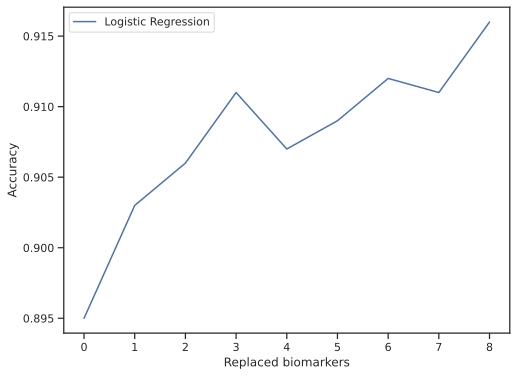

In [49]:
for clf in def_clf_dict.keys():
    if(clf == "svm"):
        label = "SVM"
    elif(clf == "svm_linear"):
        label = "Linear SVM"
    elif(clf == "log_reg"):
        label = "Logistic Regression"
    elif(clf == "lasso"):
        label = "Lasso"
    else:
        label = "Random Forest"
    plt.plot(curves_dict[clf], label=label)
plt.legend()
plt.xlabel("Replaced biomarkers")
plt.ylabel("Accuracy")
plt.savefig("graphics/replace.svg", bbox_inches = "tight")